In [4]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import randint, uniform
import statsmodels.api as sm

from rich.console import Console
from rich.table import Table
from rich.live import Live
from rich import box

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

import xgboost as xgb
from catboost import CatBoostRegressor

## XG Boost

### Load Data

In [5]:
df = pd.read_csv("..\Data\processed.csv")
print(df.head())

         street_name  price  area  air_conditioning  fridge  washing_machine  \
0          Phạm Hùng    2.8  30.0                 1       1                1   
1  Nguyễn Lương Bằng    1.3  15.0                 1       1                1   
2         Thành Thái    4.5  25.0                 1       1                1   
3               Số 8    1.2  30.0                 1       1                1   
4       Phạm Ngũ Lão    1.5  30.0                 1       1                1   

   mezzanine  kitchen  wardrobe  bed  ...  parking  month  district  \
0          1        1         0    1  ...        1     11    Quận 8   
1          1        1         1    1  ...        1     11    Quận 7   
2          1        1         0    0  ...        1     11   Quận 10   
3          1        1         1    1  ...        1     11   Thủ Đức   
4          1        1         0    1  ...        1     11    Quận 1   

   price_per_m2   latitude   longitude  dist_to_q1_km  district_median_price  \
0      0.093

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12512\2076864160.py:1: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("..\Data\processed.csv")


### Data Preparation

In [6]:
dropped = [
    "price",
]

X = df.drop(columns=dropped)
y = np.log1p(df["price"])

numerical_cols = X.select_dtypes(include=["float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool", "int64"]).columns.tolist()

### Splitting Train/Validation/Test

In [7]:
X_Train_xgb, X_test_xgb, y_Train_xgb, y_test_xgb = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_Train_xgb, y_Train_xgb,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

### Encode Categorical

In [8]:
# Create copies
X_train_encoded = X_train_xgb.copy()
X_val_encoded = X_val_xgb.copy()
X_test_encoded = X_test_xgb.copy()

# MONTH - Cyclical encoding
X_train_encoded['month_sin'] = np.sin(2 * np.pi * X_train_encoded['month'] / 12)
X_train_encoded['month_cos'] = np.cos(2 * np.pi * X_train_encoded['month'] / 12)

X_val_encoded['month_sin'] = np.sin(2 * np.pi * X_val_encoded['month'] / 12)
X_val_encoded['month_cos'] = np.cos(2 * np.pi * X_val_encoded['month'] / 12)

X_test_encoded['month_sin'] = np.sin(2 * np.pi * X_test_encoded['month'] / 12)
X_test_encoded['month_cos'] = np.cos(2 * np.pi * X_test_encoded['month'] / 12)

X_train_encoded = X_train_encoded.drop('month', axis=1)
X_val_encoded = X_val_encoded.drop('month', axis=1)
X_test_encoded = X_test_encoded.drop('month', axis=1)

# DISTRICT - Label Encoding
le_district = LabelEncoder()
X_train_encoded['district'] = le_district.fit_transform(X_train_encoded['district'])
X_val_encoded['district'] = le_district.transform(X_val_encoded['district'])
X_test_encoded['district'] = le_district.transform(X_test_encoded['district'])

# STREET_NAME - Target Encoding
# Calculate mean target per street
street_means = X_train_xgb.join(y_train_xgb.rename('target')).groupby('street_name')['target'].mean()
global_mean = y_train_xgb.mean()

# Smoothing to avoid overfitting
smoothing = 10
street_counts = X_train_xgb['street_name'].value_counts()
street_encoded = (street_means * street_counts + global_mean * smoothing) / (street_counts + smoothing)

X_train_encoded['street_name'] = X_train_encoded['street_name'].map(street_encoded).fillna(global_mean)
X_val_encoded['street_name'] = X_val_encoded['street_name'].map(street_encoded).fillna(global_mean)
X_test_encoded['street_name'] = X_test_encoded['street_name'].map(street_encoded).fillna(global_mean)

### Train

In [9]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("\nTraining model...")
xgb_model.fit(
    X_train_encoded, y_train_xgb,
    eval_set=[(X_train_encoded, y_train_xgb), (X_val_encoded, y_val_xgb)],
    verbose=100
)

print(f"\nTraining completed!")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score:.4f}")


Training model...
[0]	validation_0-rmse:0.28954	validation_1-rmse:0.28785
[100]	validation_0-rmse:0.03647	validation_1-rmse:0.05770
[200]	validation_0-rmse:0.02688	validation_1-rmse:0.05589
[297]	validation_0-rmse:0.02199	validation_1-rmse:0.05598

Training completed!
Best iteration: 247
Best score: 0.0558


In [10]:
y_pred_train = xgb_model.predict(X_train_encoded)
y_pred_val = xgb_model.predict(X_val_encoded)
y_pred_test = xgb_model.predict(X_test_encoded)

# Convert back to original scale
y_pred_train_original = np.expm1(y_pred_train)
y_pred_val_original = np.expm1(y_pred_val)
y_pred_test_original = np.expm1(y_pred_test)

y_train_original = np.expm1(y_train_xgb)
y_val_original = np.expm1(y_val_xgb)
y_test_original = np.expm1(y_test_xgb)

### Evaluate

In [11]:
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.2f} triệu VNĐ")
    print(f"  MAE:  {mae:.2f} triệu VNĐ")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

train_metrics = evaluate_model(y_train_original, y_pred_train_original, "TRAIN SET")
val_metrics = evaluate_model(y_val_original, y_pred_val_original, "VALIDATION SET")
test_metrics = evaluate_model(y_test_original, y_pred_test_original, "TEST SET")


TRAIN SET:
  RMSE: 0.24 triệu VNĐ
  MAE:  0.05 triệu VNĐ
  R²:   0.9776
  MAPE: 1.38%

VALIDATION SET:
  RMSE: 0.51 triệu VNĐ
  MAE:  0.09 triệu VNĐ
  R²:   0.8762
  MAPE: 2.27%

TEST SET:
  RMSE: 0.60 triệu VNĐ
  MAE:  0.09 triệu VNĐ
  R²:   0.8628
  MAPE: 2.35%


### Feature Importance

In [12]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))


FEATURE IMPORTANCE

Top 15 Most Important Features:
              feature  importance
         price_per_m2    0.440410
                 area    0.340423
district_median_price    0.041373
          street_name    0.029499
        dist_to_q1_km    0.016445
            longitude    0.015660
              balcony    0.014949
             wardrobe    0.013500
             latitude    0.012319
        is_hot_street    0.009485
        amenity_ratio    0.007869
             district    0.007667
            month_cos    0.006448
     air_conditioning    0.006394
            mezzanine    0.005751


### Visualize

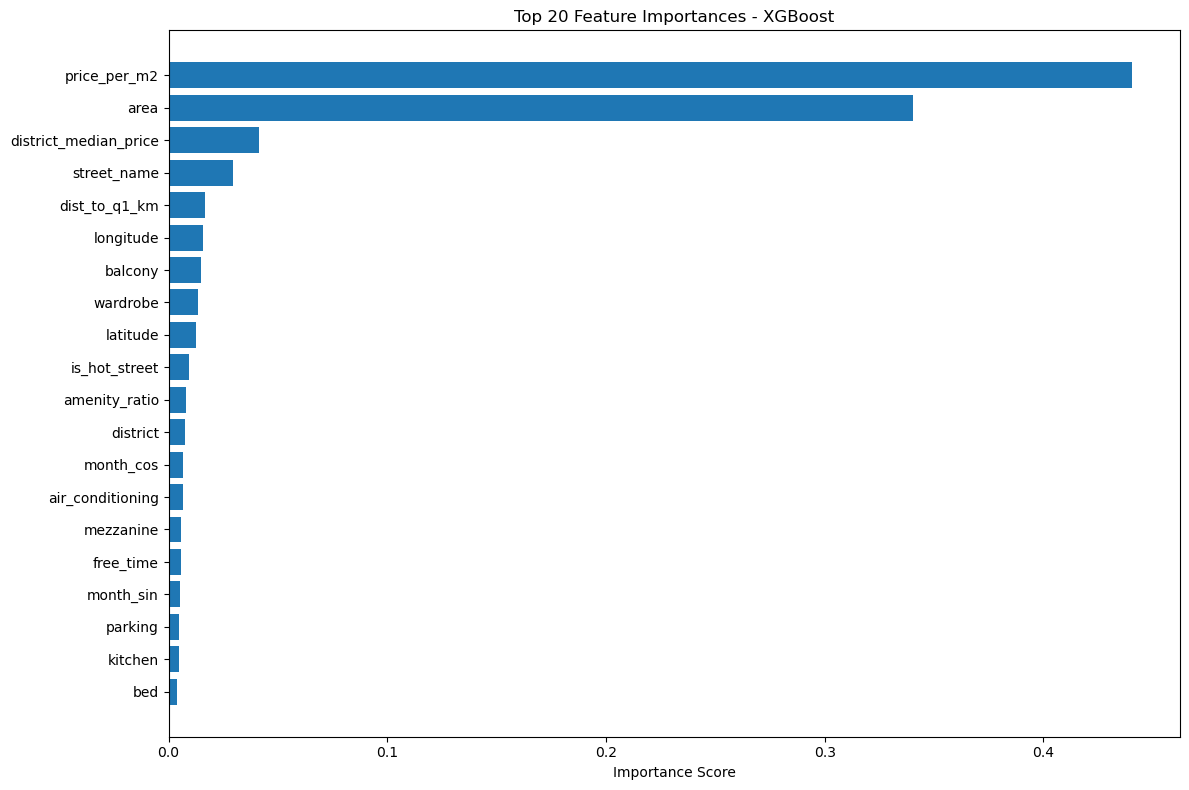

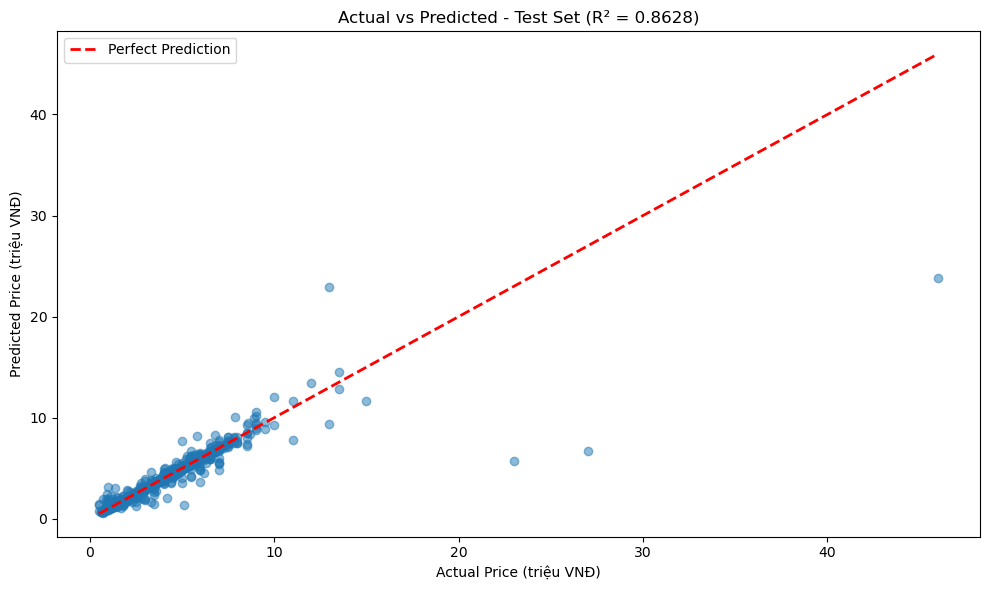

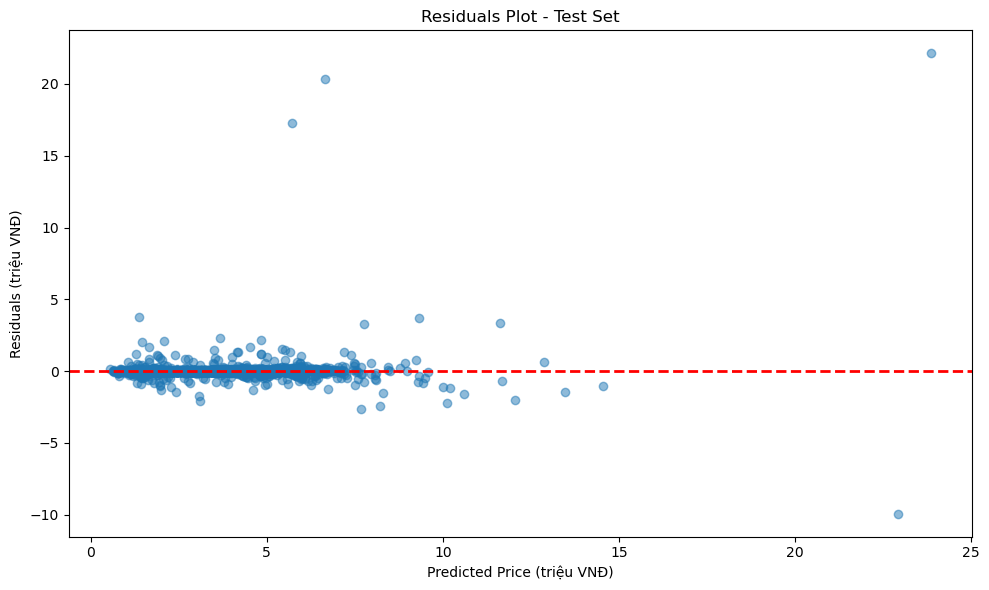

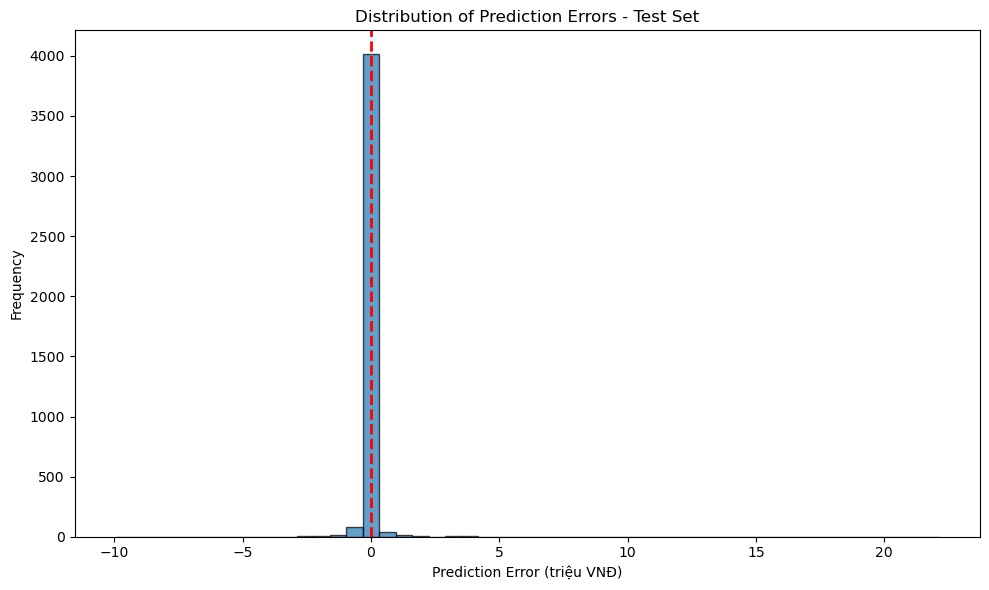

In [13]:
# 9.1 Feature Importance Plot
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()

# 9.2 Actual vs Predicted - Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (triệu VNĐ)')
plt.ylabel('Predicted Price (triệu VNĐ)')
plt.title(f'Actual vs Predicted - Test Set (R² = {test_metrics["R2"]:.4f})')
plt.legend()
plt.tight_layout()

# 9.3 Residuals Plot
plt.figure(figsize=(10, 6))
residuals = y_test_original - y_pred_test_original
plt.scatter(y_pred_test_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (triệu VNĐ)')
plt.ylabel('Residuals (triệu VNĐ)')
plt.title('Residuals Plot - Test Set')
plt.tight_layout()

# 9.4 Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (triệu VNĐ)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - Test Set')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.tight_layout()